### <span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Kinetic_fit02<br>
This nootebook solve for $k_{1}$ to $k_{7}$ recursively. (solve $k_{2}$ after solving $k_{1}$)

In [16]:
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd

<span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Read and show raw data:

In [17]:
df = pd.read_csv('kinetic_raw.csv')
df

,Time (min),A0,A1,A2,A3,A4,A5,A6
0,0.00,10043.380,0.000,0.000,0.000,0.000,0.000,0.000
1,0.25,4934.811,1222.983,221.920,46.536,60.536,113.364,0.000
2,0.50,3293.933,1933.397,410.941,64.364,90.950,164.192,0.000
3,1.00,1665.397,2432.497,912.548,171.849,127.778,296.263,0.000
4,2.00,441.941,2123.841,1757.841,477.406,244.849,656.941,0.000
5,3.00,135.849,1345.255,2108.598,859.062,513.870,1120.184,79.021
6,4.00,79.192,892.719,1968.719,1056.941,597.991,1499.841,92.435
7,5.00,0.000,408.284,1520.255,1211.355,992.062,2555.497,163.920
8,10.00,0.000,0.000,222.849,608.941,758.598,2464.841,207.577


#### <span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Normalization (fraction of intermediate):<br>
The following equation was used to normalize data as shown in Figure 1 C : https://doi.org/10.1016/j.cell.2011.05.010
$$ A_i(t) = \frac{A_i(t)}{\sum_{i=0}^{n} A_i(t)} $$

In [18]:
df = pd.concat([df['Time (min)'],df.iloc[:,1:].div(df.iloc[:,1:].sum(axis=1), axis=0)], axis=1)
df

,Time (min),A0,A1,A2,A3,A4,A5,A6
0,0.00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.25,0.747682,0.185296,0.033623,0.007051,0.009172,0.017176,0.000000
2,0.50,0.552880,0.324517,0.068976,0.010803,0.015266,0.027559,0.000000
3,1.00,0.297056,0.433884,0.162771,0.030653,0.022792,0.052844,0.000000
4,2.00,0.077495,0.372419,0.308241,0.083714,0.042935,0.115196,0.000000
5,3.00,0.022047,0.218320,0.342203,0.139416,0.083396,0.181794,0.012824
6,4.00,0.012798,0.144270,0.318159,0.170809,0.096640,0.242385,0.014938
7,5.00,0.000000,0.059592,0.221891,0.176805,0.144798,0.372990,0.023925
8,10.00,0.000000,0.000000,0.052278,0.142850,0.177957,0.578220,0.048695


<span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Build python function mimicing the equation:
$$ A_i(t) = \prod_{j=1}^i k_j \sum_{j=1}^{i+1} \frac{e^{-k_jt}}{\prod_{p=1,p\neq j}^{i+1}(k_p-k_j)} \qquad i=1...n $$

In [19]:
def A_i(t, *k_values):
    """
    Calculates A_i(t) for a given set of k values (k1, k2, ..., k_(i+1)).
    Designed for use with scipy.optimize.curve_fit.

    Args:
        t: Time variable.
        *k_values: Variable number of rate constants (k1, k2, ..., k_(i+1)).

    Returns:
        The value of A_i(t).
        Returns np.nan if any two k values are equal to avoid division by zero.

    Raises:
        ValueError: If the number of k_values is less than 2.

    """


    n = len(k_values)  # n=i in A_i

    if not 2 <= n:
        raise ValueError("The number of k_values must be higher than 2.")

    i = n - 1 
    
    # for j in range(i+1):
    #     for p in range(j+1,i+1):
    #         if k_values[j]==k_values[p]:
    #             return np.nan #return nan if two k values are the same
            
    # for j in range(i + 1):
    #     for p in range(j+1,i+1):
    #         if abs(k_values[p] - k_values[j]) < 1e-6: #Check if the difference is extremely small
    #             return 100  # Return a large value (or appropriate default)

    product_k = np.prod(k_values[:i])
    sum_terms = 0

    for j in range(i + 1):
        numerator = np.exp(-k_values[j] * t)
        denominator = 1
        for p in range(i + 1):
            if p != j:
                denominator *= (k_values[p] - k_values[j])
        denominator = 1e-8 if abs(denominator) < 1e-8 else denominator # bypass dividing by zero
        sum_terms += numerator / denominator

    return product_k * sum_terms

<span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Python function to plot the experimental values and the fit along with estimated k_values.

In [20]:
def plot_fit(t, A, t_, parm, ylabel):
    """
    Plots data, fit, and displays parameter values.

    Args:
        t: Time data.
        A: Observed data.
        t_: Time data for the fitted curve.
        parm: List of fitted parameters.
        ylabel: Y-axis label.
    """

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(t, A, label='EXPERIMENTAL')
    ax.plot(t_, A_i(t_, *parm), 'r--', label='FIT')
    ax.set_xlabel('TIME (min)', fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.legend(fontsize=14)

    # Add parameter values as text outside the plot area
    textstr = '\n'.join([f'$k_{{{i+1}}} = {val:.3f}$' for i, val in enumerate(parm)])  # Format to 2 decimal places
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)  # Styling for text box
    ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
            verticalalignment='top', bbox=props)  # Position and style the text


    plt.tight_layout()
    plt.show()

### <span style="color: #f2cf4a; font-family: monospace; font-size: 1em;">1. Solving for k<sub>1</sub> ... k<sub>7</sub> using A6

In [21]:
def A_6(t, k1, k2, k3, k4, k5, k6, k7):
    return A_i(t, k1, k2, k3, k4, k5, k6, k7)

In [22]:
A6 = df['A6'][:] 
t  = df['Time (min)'][:]

popt, pcov = curve_fit(A_6, xdata=np.array(t), ydata=np.array(A6), method='lm')

/var/folders/n7/_y8t98tx1dnf1hl4jv06wsn40000gn/T/ipykernel_60039/751930095.py:41: RuntimeWarning: overflow encountered in exp
  numerator = np.exp(-k_values[j] * t)


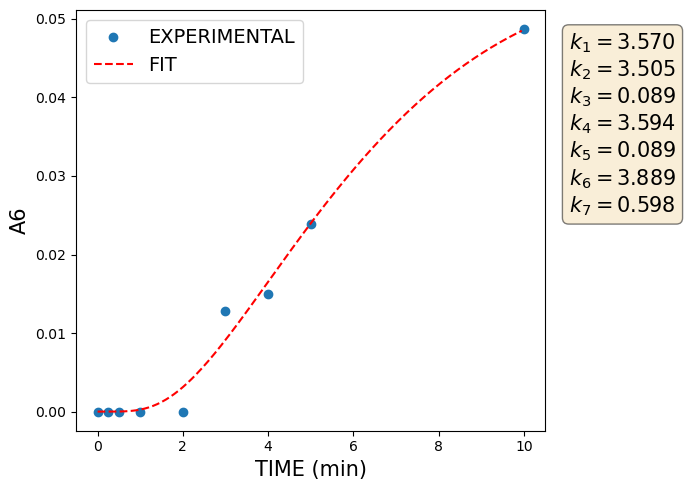

In [23]:
plot_fit(t, A6, t_=np.arange(0,10,0.05), parm=popt, ylabel='A6')

### <span style="color: #f2cf4a; font-family: monospace; font-size: 1em;">2. Solving for k<sub>1</sub>, k<sub>6</sub> using A5

In [24]:
def A_5(t, k1, k2, k3, k4, k5, k6):
    return A_i(t, k1, k2, k3, k4, k5, k6)

In [25]:
A5 = df['A5'][:] 
t  = df['Time (min)'][:]

popt, pcov = curve_fit(A_5, xdata=np.array(t), ydata=np.array(A5), method='lm', p0=list(popt[:-1]))

/var/folders/n7/_y8t98tx1dnf1hl4jv06wsn40000gn/T/ipykernel_60039/751930095.py:41: RuntimeWarning: overflow encountered in exp
  numerator = np.exp(-k_values[j] * t)
/var/folders/n7/_y8t98tx1dnf1hl4jv06wsn40000gn/T/ipykernel_60039/751930095.py:47: RuntimeWarning: invalid value encountered in add
  sum_terms += numerator / denominator


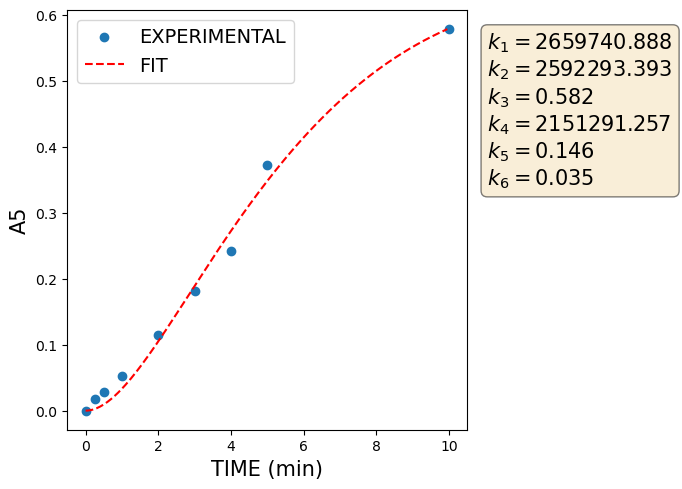

In [26]:
plot_fit(t, A5, t_=np.arange(0,10,0.05), parm=popt, ylabel='A5')

### <span style="color: #f2cf4a; font-family: monospace; font-size: 1em;">3. Solving for k<sub>1</sub> ... k<sub>5</sub> using A4

In [27]:
def A_4(t, k1, k2, k3, k4, k5):
    return A_i(t, k1, k2, k3, k4, k5)

In [28]:
A4 = df['A4'][:] 
t  = df['Time (min)'][:]

popt, pcov = curve_fit(A_4, xdata=np.array(t), ydata=np.array(A4), method='lm', p0=list(popt[:-1]))

/var/folders/n7/_y8t98tx1dnf1hl4jv06wsn40000gn/T/ipykernel_60039/751930095.py:41: RuntimeWarning: overflow encountered in exp
  numerator = np.exp(-k_values[j] * t)
/var/folders/n7/_y8t98tx1dnf1hl4jv06wsn40000gn/T/ipykernel_60039/751930095.py:47: RuntimeWarning: invalid value encountered in add
  sum_terms += numerator / denominator


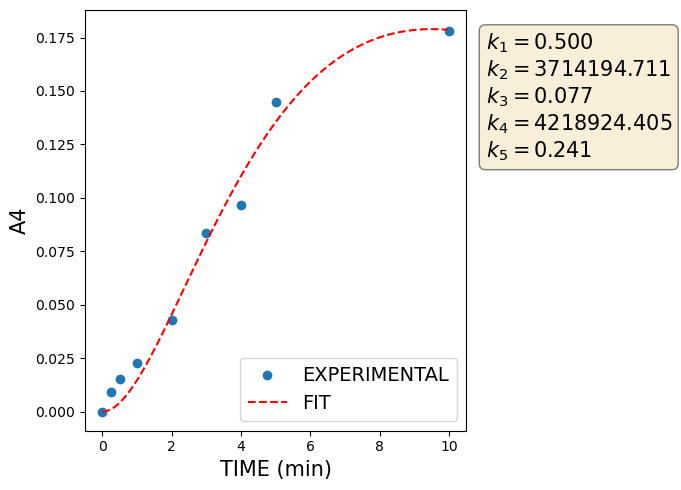

In [30]:
plot_fit(t, A4, t_=np.arange(0,10,0.05), parm=popt, ylabel='A4')

### <span style="color: #f2cf4a; font-family: monospace; font-size: 1em;">4. Solving for k<sub>1</sub> ... k<sub>4</sub> using A3

In [ ]:
def A_3(t, k1, k2, k3, k4):
    return A_i(t, k1, k2, k3, k4)

In [ ]:
A3 = df['A3'][1:] # Read only non-zero A2
t  = df['Time (min)'][1:]

# popt, pcov = curve_fit(A_3, xdata=np.array(t), ydata=np.array(A3),  p0=np.append(popt,0.0), maxfev=10000,
#                        method='dogbox')
popt, pcov = curve_fit(A_3, xdata=np.array(t), ydata=np.array(A3), method='dogbox', bounds=([0.8,0.4,0.2,-100],[1.4,1.0,0.8,100]))

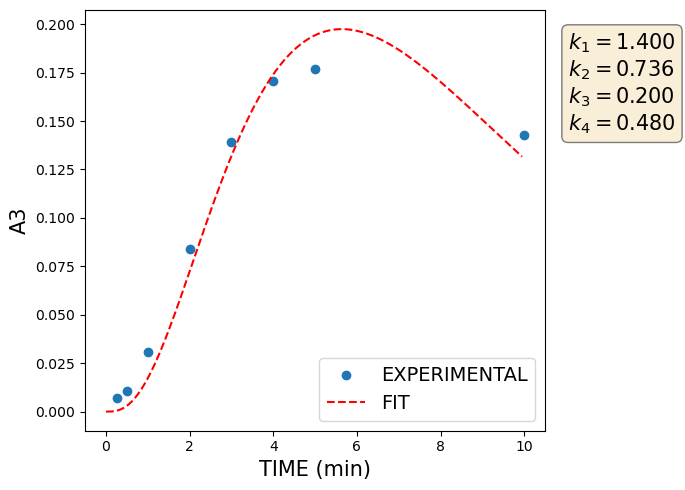

In [ ]:
plot_fit(t, A3, t_=np.arange(0,10,0.05), parm=popt, ylabel='A3')

### <span style="color: #f2cf4a; font-family: monospace; font-size: 1em;">5. Solving for k<sub>1</sub> ... k<sub>5</sub> using A4

In [ ]:
def A_4(t, k1, k2, k3, k4, k5):
    return A_i(t, k1, k2, k3, k4, k5)

In [ ]:
A4 = df['A4'][1:] # Read only non-zero A2
t  = df['Time (min)'][1:]

popt, pcov = curve_fit(A_4, xdata=np.array(t), ydata=np.array(A4), method='dogbox', bounds=([0.8,0.4,0.2,0.2,-100],[1.4,1.0,0.8,0.8,100]))

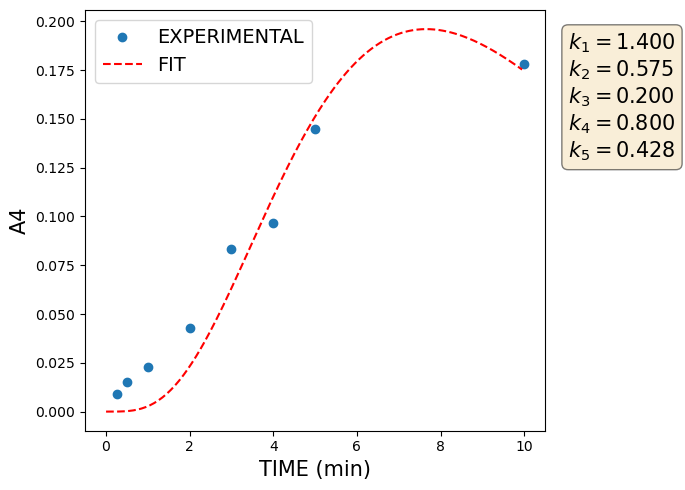

In [ ]:
plot_fit(t, A4, t_=np.arange(0,10,0.05), parm=popt, ylabel='A4')

### <span style="color: #f2cf4a; font-family: monospace; font-size: 1em;">6. Solving for k<sub>1</sub> ... k<sub>6</sub> using A5

In [ ]:
def A_5(t, k1, k2, k3, k4, k5, k6):
    return A_i(t, k1, k2, k3, k4, k5, k6)

In [ ]:
A5 = df['A5'][1:] # Read only non-zero A5
t  = df['Time (min)'][1:]

popt, pcov = curve_fit(A_5, xdata=np.array(t), ydata=np.array(A5), method='dogbox', bounds=([0.8,0.4,0.2,0.2,0.1,-100],[1.4,1.0,0.8,0.8,0.7,100]))

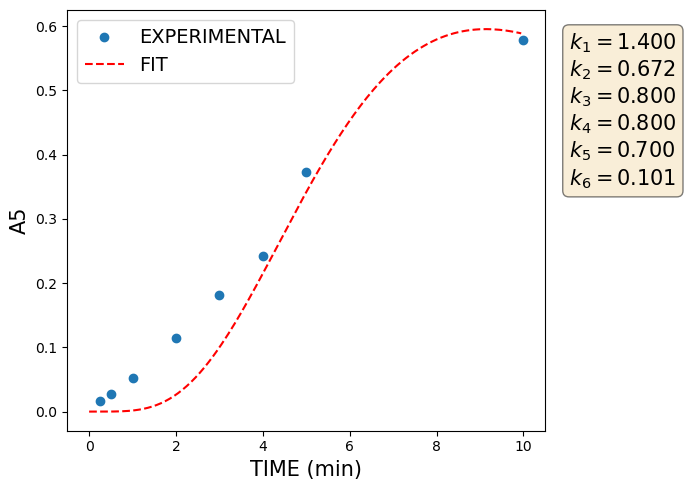

In [ ]:
plot_fit(t, A5, t_=np.arange(0,10,0.05), parm=popt, ylabel='A5')